In [23]:
import pickle
import os
from collections import defaultdict
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
from graphviz import Digraph
import pygraphviz
%matplotlib inline

In [24]:
# initialize graph
G = nx.DiGraph()

circuit_path = "../nounpp_circuit.pkl"
circuit_figure_filename = os.path.basename(circuit_path).split(".pkl")[0] + ".png"
circuit_figure_path = os.path.join("../figures/circuits", circuit_figure_filename)

# load dictionary
with open(circuit_path, "rb") as circuit_pickle:
    circuit = pickle.load(circuit_pickle)

FileNotFoundError: [Errno 2] No such file or directory: '../nounpp_circuit.pkl'

In [ ]:
G.graph['node'] = {'shape': 'box', 'style': 'rounded'}
G.graph['graph'] = {'rankdir': 'BT'}
textcolor = "black"     # easy to change in case we use colors where white text will look better

for parent in circuit:
    if parent not in G.nodes:
        if "mlp" in parent:
            nodecolor = "#e5ad76"   # camel
        elif "attn" in parent:
            nodecolor = "#5baf7e"   # kelly green
        elif "resid" in parent:
            nodecolor = "#88a7cd"   # pastel steel blue
        else:
            nodecolor = "white"

        if parent != "y":
            layer, feat_idx, component = parent.split("_")
            nodename = f"{component}_{layer}/{feat_idx}"
            rank = int(layer) + 2
        else:
            nodename = "y"
            rank = 1
        G.add_node(parent, label=nodename, style="rounded,filled", fillcolor=nodecolor, fontcolor=textcolor,
                   rank=rank)
    for child in circuit[parent]:
        child_name, child_effect = child
        if child_name not in G.nodes:
            if "mlp" in child_name:
                nodecolor = "#e5ad76"
            elif "attn" in child_name:
                nodecolor = "#5baf7e"
            elif "resid" in child_name:
                nodecolor = "#88a7cd"
            else:
                nodecolor = "white"
            
            layer, feat_idx, component = child_name.split("_")
            rank = int(layer) + 2
            nodename = f"{component}_{layer}/{feat_idx}"
            G.add_node(child_name, label=nodename, style="rounded,filled", fillcolor=nodecolor, fontcolor=textcolor,
                       rank=rank)
        G.add_edge(child_name, parent)

A = to_agraph(G)
A.layout('dot')
print(A)

# if not os.path.exists("../figures/circuits/"):
#     os.makedirs("../figures/circuits/")
# A.draw(circuit_figure_path)

NameError: name 'circuit' is not defined

# Depth by Layer Index

In [ ]:
# initialize graph
G = Digraph(name="Feature Circuit")
G.graph_attr.update(rankdir='BT', newrank='true')
G.node_attr.update(shape="box", style="rounded")

circuit_path = "../circuits/contexts_lin-effects_final1pos_nclusters500_clusteridx72_circuit_threshold0.01_aggfinal-pos-only_patchseparate_seed1_chain_nopair_logprob.pkl"
circuit_figure_filename = os.path.basename(circuit_path).split(".pkl")[0]
circuit_figure_path = os.path.join("../figures/circuits", circuit_figure_filename)

# load dictionary
with open(circuit_path, "rb") as circuit_pickle:
    circuit = pickle.load(circuit_pickle)

y_effects = []
other_effects = []
for parent in circuit:
    for child in circuit[parent]:
        if parent == "y":
            y_effects.append(child[1])
        else:
            other_effects.append(child[1])

min_y_effect, mean_y_effect, max_y_effect = min(y_effects), np.mean(y_effects), max(y_effects)
min_o_effect, mean_o_effect, max_o_effect = min(other_effects), np.mean(other_effects), max(other_effects)

min_weight, max_weight = 0.25, 3.5

# G.graph['node'] = {'shape': 'box', 'style': 'rounded'}
# G.graph['graph'] = {'rankdir': 'BT', 'compound': 'true'}
textcolor = "black"     # easy to change in case we use colors where white text will look better

nodes_by_layer = defaultdict(list)
edges = defaultdict(list)
nodeset = set()

for parent in circuit:
    if parent not in nodeset:
        if "mlp" in parent:
            nodecolor = "#e5ad76"   # camel
        elif "attn" in parent:
            nodecolor = "#5baf7e"   # kelly green
        elif "resid" in parent:
            nodecolor = "#88a7cd"   # pastel steel blue
        else:
            nodecolor = "white"

        if parent != "y":
            layer, feat_idx, component = parent.split("_")
            nodename = f"{component}_{layer}/{feat_idx}"
            rank = int(layer) + 2
        else:
            nodename = "y"
            feat_idx, component = None, None
            layer = 60
        layer = int(layer)
        nodes_by_layer[layer].append((parent, nodename, nodecolor, layer, feat_idx, component, None))
        nodeset.add(parent)
        # G.add_node(parent, label=nodename, style="rounded,filled", fillcolor=nodecolor, fontcolor=textcolor,
        #            rank=rank)
    for child in circuit[parent]:
        child_name, child_effect = child
        if child_name not in nodeset:
            if "mlp" in child_name:
                nodecolor = "#e5ad76"
            elif "attn" in child_name:
                nodecolor = "#5baf7e"
            elif "resid" in child_name:
                nodecolor = "#88a7cd"
            else:
                nodecolor = "white"
            
            layer, feat_idx, component = child_name.split("_")
            nodename = f"{component}_{layer}/{feat_idx}"
            layer = int(layer)
            nodes_by_layer[layer].append((child_name, nodename, nodecolor, layer, feat_idx, component))
        
                    # compute edge weight
        if parent == "y":
            coef = (child_effect - min_y_effect) / (max_y_effect - min_y_effect)
        else:
            coef = (child_effect - min_o_effect) / (max_o_effect - min_o_effect)
        weight = coef * (max_weight - min_weight) + min_weight
        edges[child_name].append((parent, weight))
        nodeset.add(child_name)
        #     G.add_node(child_name, label=nodename, style="rounded,filled", fillcolor=nodecolor, fontcolor=textcolor,
        #                rank=rank)
        # G.add_edge(child_name, parent)

# subgraphs = []
first_node_per_layer = []
for layer in sorted(nodes_by_layer, reverse=True):
    with G.subgraph(name=f"layer {layer}") as subgraph:
        subgraph.attr(rank='same')
        for idx, node in enumerate(nodes_by_layer[layer]):
            if idx == 0:
                first_node_per_layer.append(node[0])
            subgraph.node(node[0], label=node[1], style="rounded,filled", fillcolor=node[2])
        # print(subgraph)
    # subgraphs.append(subgraph)

for child_node in edges:
    for parent_tuple in edges[child_node]:
        parent_node, weight = parent_tuple
        G.edge(child_node, parent_node, penwidth=str(weight), color=)

# add invisible edges to make layer-based ranking work
for idx in range(len(first_node_per_layer)-1):
    G.edge(first_node_per_layer[idx+1], first_node_per_layer[idx], style="invis")


# for subgraph in subgraphs:
#     # print(subgraph)
#     G.add_subgraph(subgraph)

# G.layout('dot')
# print(G)
# G.render(circuit_figure_path, format="png")
G

# A = to_agraph(G)
# A.layout('dot')
# print(A)

FileNotFoundError: [Errno 2] No such file or directory: '../circuits/contexts_lin-effects_final1pos_nclusters500_clusteridx72_circuit_threshold0.01_aggfinal-pos-only_patchseparate_seed1_chain_nopair_logprob.pkl'

# Label nodes in circuit

In [ ]:
# initialize graph
G = Digraph(name="Feature Circuit")
G.graph_attr.update(rankdir='BT', newrank='true')
G.node_attr.update(shape="box", style="rounded")

circuit_path = "../circuits/simple_dag_node0.1_edge0.01.pkl"
circuit_figure_filename = os.path.basename(circuit_path).split(".pkl")[0]
circuit_figure_path = os.path.join("../figures/circuits", circuit_figure_filename)

# load dictionary
with open(circuit_path, "rb") as circuit_pickle:
    circuit = pickle.load(circuit_pickle)

y_effects = []
other_effects = []
for parent in circuit:
    for child in circuit[parent]:
        if parent == "y":
            y_effects.append(child[1])
        else:
            other_effects.append(child[1])
            
min_y_effect, mean_y_effect, max_y_effect = min(y_effects), np.mean(y_effects), max(y_effects)
min_o_effect, mean_o_effect, max_o_effect = min(other_effects), np.mean(other_effects), max(other_effects)

min_weight, max_weight = 0.25, 3.5

# G.graph['node'] = {'shape': 'box', 'style': 'rounded'}
# G.graph['graph'] = {'rankdir': 'BT', 'compound': 'true'}
textcolor = "black"     # easy to change in case we use colors where white text will look better

nodes_by_layer = defaultdict(list)
edges = defaultdict(list)
nodeset = set()

for parent in circuit:
    if parent not in nodeset:
        if "mlp" in parent:
            nodecolor = "#e5ad76"   # camel
        elif "attn" in parent:
            nodecolor = "#5baf7e"   # kelly green
        elif "resid" in parent:
            nodecolor = "#88a7cd"   # pastel steel blue
        else:
            nodecolor = "white"

        if parent != "y":
            layer, feat_idx, component = parent.split("_")
            nodename = f"{component}_{layer}/{feat_idx}"
            rank = int(layer) + 2
        else:
            nodename = "y"
            feat_idx, component = None, None
            layer = 60
        layer = int(layer)
        nodes_by_layer[layer].append((parent, nodename, nodecolor, layer, feat_idx, component))
        nodeset.add(parent)
        # G.add_node(parent, label=nodename, style="rounded,filled", fillcolor=nodecolor, fontcolor=textcolor,
        #            rank=rank)
    for child in circuit[parent]:
        child_name, child_effect = child
        if child_name not in nodeset:
            if "mlp" in child_name:
                nodecolor = "#e5ad76"
            elif "attn" in child_name:
                nodecolor = "#5baf7e"
            elif "resid" in child_name:
                nodecolor = "#88a7cd"
            else:
                nodecolor = "white"
            
            layer, feat_idx, component = child_name.split("_")
            nodename = f"{component}_{layer}/{feat_idx}"
            layer = int(layer)
            nodes_by_layer[layer].append((child_name, nodename, nodecolor, layer, feat_idx, component))
        
        if parent == "y":
            coef = (child_effect - min_y_effect) / (max_y_effect - min_y_effect)
        else:
            coef = (child_effect - min_o_effect) / (max_o_effect - min_o_effect)
        weight = coef * (max_weight - min_weight) + min_weight
        edges[child_name].append((parent, weight))
        nodeset.add(child_name)
        #     G.add_node(child_name, label=nodename, style="rounded,filled", fillcolor=nodecolor, fontcolor=textcolor,
        #                rank=rank)
        # G.add_edge(child_name, parent)

INDEX_TO_LABEL = {
    "attn_5/7857": "Predictive of plural or infinitive verb forms",
    "attn_4/30664": "RC and PP end boundary detector",
    "attn_4/25640": "PP end boundary detector",
    "attn_2/27261": "RC main verb detector",
    "resid_2/15844": "inside PP",
    "resid_3/12113": "RC end boundary detector",
    "resid_4/5740": "clause end boundary detector",
    "resid_5/20133": "plural nouns and pronouns",
    "resid_4/15675": "PP end boundary detector",
    "resid_5/29911": "singular nouns and relative pronouns",
    "resid_5/32503": "plural nouns",
    "resid_4/26966": "plural nouns",
    "mlp_5/4895": "clause adverbs (any position)",
    "mlp_0/13858": "however",
    "resid_5/24005": "clause adverbs (any position)",
    "resid_0/13434": "however",
    "resid_2/14142": "clause adverbs (sentence initial)",
    "resid_2/22828": "conjunctions and adverbs (although, yet)",
    "resid_3/12270": "subordinate conjunctions (any position)",
    "resid_4/26604": "clause adverbs",
    "resid_3/20573": "conjunctions (sentence initial)",
    "attn_1/27778": "adverbs after commas",
    "resid_1/7558": "adverbs after commas",
    "resid_1/2690": "clause adverbs (sentence initial)",
    "y": "y"
}

# subgraphs = []
first_node_per_layer = []
for layer in sorted(nodes_by_layer, reverse=True):
    with G.subgraph(name=f"layer {layer}") as subgraph:
        subgraph.attr(rank='same')
        for idx, node in enumerate(nodes_by_layer[layer]):
            if idx == 0:
                first_node_per_layer.append(node[0])
            
            if node[1] in INDEX_TO_LABEL:
                label = INDEX_TO_LABEL[node[1]]
            else:
                label = node[1]
            subgraph.node(node[0], label=label, style="rounded,filled", fillcolor=node[2])
        # print(subgraph)
    # subgraphs.append(subgraph)

for child_node in edges:
    for parent_tuple in edges[child_node]:
        parent_node, weight = parent_tuple
        G.edge(child_node, parent_node, penwidth=str(weight))

# add invisible edges to make layer-based ranking work
for idx in range(len(first_node_per_layer)-1):
    G.edge(first_node_per_layer[idx+1], first_node_per_layer[idx], style="invis")


# for subgraph in subgraphs:
#     # print(subgraph)
#     G.add_subgraph(subgraph)

# G.layout('dot')
# print(G)
G.render(circuit_figure_path, format="png")

# A = to_agraph(G)
# A.layout('dot')
# print(A)
G

IndexError: string index out of range

# DAG Circuit Plotting

mlp_0/[18832] y
mlp_0/[15910] y
mlp_0/[3855] y
mlp_0/[9965] y
mlp_0/[8507] y
mlp_0/[3504] y
resid_0/[13833] y
resid_0/[1198] y
resid_0/[31494] y
mlp_1/[5594] y
resid_1/[17887] y
resid_1/[28150] y
resid_1/[10917] y
resid_2/[26904] y
resid_2/[21365] y
resid_2/[15807] y
resid_2/[13060] y
resid_2/[26429] y
resid_3/[21519] y
resid_3/[14341] y
mlp_4/[26707] y
mlp_4/[10980] y
resid_4/[31988] y
resid_4/[18976] y
resid_4/[14763] y
resid_5/[29911] y
resid_5/[20133] y
resid_5/[2640] y
resid_5/[1593] y
resid_5/[296] y


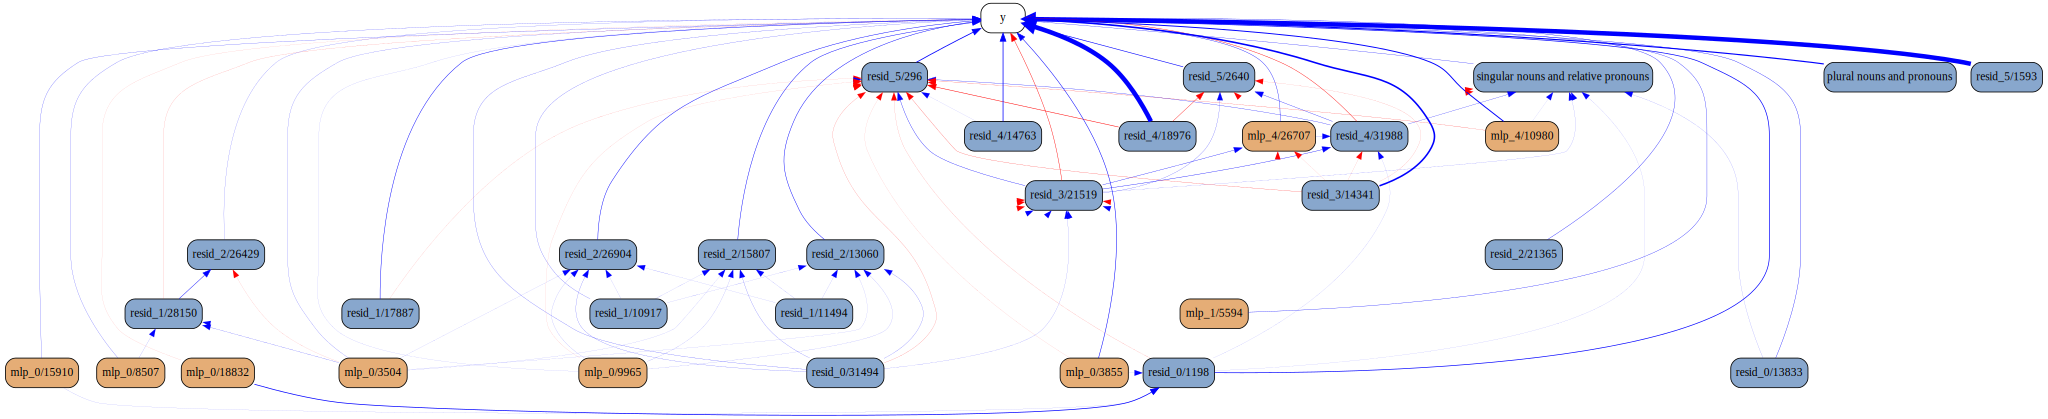

In [26]:
# initialize graph
G = Digraph(name="Feature Circuit")
G.graph_attr.update(rankdir='BT', newrank='true')
G.node_attr.update(shape="box", style="rounded")

circuit_path = "../test_circuit3.pkl"
circuit_figure_filename = os.path.basename(circuit_path).split(".pkl")[0]
circuit_figure_path = os.path.join("../figures/circuits", circuit_figure_filename)

# load dictionary
with open(circuit_path, "rb") as circuit_pickle:
    circuit, nodes = pickle.load(circuit_pickle)

effects = []
for child in circuit:
    for parent in circuit[child]:
        if parent == "y":
            effects.append(circuit[child][parent])
            
#min_effect, mean_effect, max_effect = min(effects), np.mean(effects), max(effects)

min_weight, max_weight = 0.25, 3.5

# G.graph['node'] = {'shape': 'box', 'style': 'rounded'}
# G.graph['graph'] = {'rankdir': 'BT', 'compound': 'true'}
textcolor = "black"     # easy to change in case we use colors where white text will look better

nodes_by_layer = defaultdict(list)
edges = defaultdict(list)
nodeset = set()

for child in circuit:
    if child not in nodeset:
        if "mlp" in child:
            nodecolor = "#e5ad76"   # camel
        elif "attn" in child:
            nodecolor = "#5baf7e"   # kelly green
        elif "resid" in child:
            nodecolor = "#88a7cd"   # pastel steel blue
        else:
            nodecolor = "white"

        component, layer_index = child.split("_")
        layer, feat_idx = layer_index.split("/")
        feat_idx = feat_idx.replace("[", "").replace("]", "")
        nodename = f"{component}_{layer}/{feat_idx}"
        rank = int(layer) + 2
        layer = int(layer)        
        nodes_by_layer[layer].append((child, nodename, nodecolor, layer, feat_idx, component))
        nodeset.add(child)

    for parent in circuit[child]:
        parent_name = parent
        parent_effect = circuit[child][parent]
        if "mlp" in parent_name:
            nodecolor = "#e5ad76"
        elif "attn" in parent_name:
            nodecolor = "#5baf7e"
        elif "resid" in parent_name:
            nodecolor = "#88a7cd"
        else:
            nodecolor = "white"
        
        if parent_name == "y":
            layer = 60
            component, feat_idx = None, None
            nodename = "y"
        else:
            component, layer_index = parent_name.split("_")
            layer, feat_idx = layer_index.split("/")
            feat_idx = feat_idx.replace("[", "").replace("]", "")
            nodename = f"{component}_{layer}/{feat_idx}"
            rank = int(layer) + 2
            layer = int(layer)

        if parent_name not in nodeset:
            nodes_by_layer[layer].append((parent_name, nodename, nodecolor, layer, feat_idx, component))
    
        coef = parent_effect# (parent_effect - min_effect) / (max_effect - min_effect)
        weight = coef * 3 #* (max_weight - min_weight) + min_weight
        edges[child].append((parent_name, weight))
        nodeset.add(parent_name)

INDEX_TO_LABEL = {
    "attn_5/7857": "Predictive of plural or infinitive verb forms",
    "attn_4/30664": "RC and PP end boundary detector",
    "attn_4/25640": "PP end boundary detector",
    "attn_2/27261": "RC main verb detector",
    "resid_2/15844": "inside PP",
    "resid_3/12113": "RC end boundary detector",
    "resid_4/5740": "clause end boundary detector",
    "resid_5/20133": "plural nouns and pronouns",
    "resid_4/15675": "PP end boundary detector",
    "resid_5/29911": "singular nouns and relative pronouns",
    "resid_5/32503": "plural nouns",
    "resid_4/26966": "plural nouns",
    "mlp_5/4895": "clause adverbs (any position)",
    "mlp_0/13858": "however",
    "resid_5/24005": "clause adverbs (any position)",
    "resid_0/13434": "however",
    "resid_2/14142": "clause adverbs (sentence initial)",
    "resid_2/22828": "conjunctions and adverbs (although, yet)",
    "resid_3/12270": "subordinate conjunctions (any position)",
    "resid_4/26604": "clause adverbs",
    "resid_3/20573": "conjunctions (sentence initial)",   
    "attn_1/27778": "adverbs after commas",
    "resid_1/7558": "adverbs after commas",
    "resid_1/2690": "clause adverbs (sentence initial)",
    "y": "y"
}

# subgraphs = []
first_node_per_layer = []
for layer in sorted(nodes_by_layer, reverse=True):
    with G.subgraph(name=f"layer {layer}") as subgraph:
        subgraph.attr(rank='same')
        for idx, node in enumerate(nodes_by_layer[layer]):
            if idx == 0:
                first_node_per_layer.append(node[0])
            
            if node[1] in INDEX_TO_LABEL:
                label = INDEX_TO_LABEL[node[1]]
            else:
                label = node[1]
            subgraph.node(node[0], label=label, style="rounded,filled", fillcolor=node[2])
        # print(subgraph)
    # subgraphs.append(subgraph)

for child_node in edges:
    for parent_tuple in edges[child_node]:
        parent_node, weight = parent_tuple
        if parent_node == "y":
            print(child_node, parent_node)
        G.edge(child_node, parent_node, penwidth=str(abs(weight)), color='blue' if weight > 0 else 'red')

# add invisible edges to make layer-based ranking work
for idx in range(len(first_node_per_layer)-1):
    G.edge(first_node_per_layer[idx+1], first_node_per_layer[idx], style="invis")


# for subgraph in subgraphs:
#     # print(subgraph)
#     G.add_subgraph(subgraph)

# G.layout('dot')
# print(G)
G.render(circuit_figure_path, format="png")

# A = to_agraph(G)
# A.layout('dot')
# print(A)
G

In [7]:
for node in circuit:
    effects_out = sum([circuit[node][child] for child in circuit[node]])
    node_effect = nodes[node]
    print(f"{node}: {node_effect} vs. {effects_out}")

resid_5/[0, 1, 296]: 0.2597629725933075 vs. 0.2597629725933075
resid_5/[0, 1, 1593]: 1.7791684865951538 vs. 1.7791684865951538
resid_5/[0, 1, 2640]: 0.22006548941135406 vs. 0.22006548941135406
resid_5/[0, 1, 20133]: 0.3572933077812195 vs. 0.3572933077812195
resid_4/[0, 1, 14763]: 0.32983705401420593 vs. 0.32983704621437937
resid_4/[0, 1, 18976]: 1.5237325429916382 vs. 1.523732602596283
resid_4/[0, 1, 22899]: 0.1925659030675888 vs. 0.19256591238081455
resid_4/[0, 1, 31988]: 0.11127912998199463 vs. 0.11127912998199463
mlp_4/[0, 1, 10980]: 0.3586975336074829 vs. 0.35869755363091826
mlp_4/[0, 1, 16421]: 0.11342518031597137 vs. 0.11342518357560039
resid_3/[0, 1, 7325]: 0.12288513034582138 vs. 0.12288512825034559
resid_3/[0, 1, 14341]: 0.5945993065834045 vs. 0.5945993214845657
resid_3/[0, 1, 16296]: 0.12831151485443115 vs. 0.12831152137368917
resid_3/[0, 1, 21519]: 0.2843092083930969 vs. 0.2843092381954193
resid_2/[0, 1, 13060]: 0.2085915058851242 vs. 0.2085915036732331
resid_2/[0, 1, 15807]

In [11]:
nodes

{'y': 4.1763916015625,
 'mlp_0/[9965]': 0.2696899473667145,
 'mlp_0/[8507]': 0.22172202169895172,
 'mlp_0/[3504]': 0.3562600314617157,
 'resid_0/[31494]': 0.6033332943916321,
 'resid_0/[2980]': 0.1676798015832901,
 'mlp_1/[5594]': 0.22092360258102417,
 'resid_1/[28150]': 0.2843446731567383,
 'resid_1/[11494]': 0.2075418084859848,
 'resid_1/[10917]': 0.3055446743965149,
 'resid_2/[26904]': 0.2085915058851242,
 'resid_2/[26429]': 0.27623888850212097,
 'resid_2/[15807]': 0.2085915058851242,
 'resid_2/[13060]': 0.2085915058851242,
 'resid_3/[21519]': 0.2843092083930969,
 'resid_3/[16296]': 0.12831151485443115,
 'resid_3/[14341]': 0.5945993065834045,
 'resid_3/[7325]': 0.12288513034582138,
 'mlp_4/[16421]': 0.11342518031597137,
 'mlp_4/[10980]': 0.3586975336074829,
 'resid_4/[31988]': 0.11127912998199463,
 'resid_4/[22899]': 0.1925659030675888,
 'resid_4/[18976]': 1.5237325429916382,
 'resid_4/[14763]': 0.32983705401420593,
 'resid_5/[20133]': 0.3572933077812195,
 'resid_5/[2640]': 0.220065

In [8]:
for node in circuit:
    effects_out = sum([circuit[node][child] for child in circuit[node]])
    effects_in = sum([circuit[child][node] for child in circuit if node in circuit[child]])
    print(node, effects_out, effects_in)

mlp_0/[9965] 0.34211540594697 0
mlp_0/[8507] 0.23453646432608366 0
mlp_0/[3504] 0.42475757375359535 0
resid_0/[31494] 0.73208306171 0
resid_0/[2980] 0.17263441439718008 0
mlp_1/[5594] 0.23623192589730024 0
resid_1/[28150] 0.34497008193284273 0.30464637465775013
resid_1/[11494] 0.2045131865888834 0
resid_1/[10917] 0.36517482437193394 0
resid_2/[26904] 0.2588318781927228 0.37482095044106245
resid_2/[26429] 0.27726183366030455 0.3325449526309967
resid_2/[15807] 0.2588318781927228 0.37482095044106245
resid_2/[13060] 0.2588318781927228 0.37482095044106245
resid_3/[21519] 0.40508922189474106 0.198987677693367
resid_3/[16296] 0.11945142410695553 0.30412027798593044
resid_3/[14341] 0.7647378444671631 0
resid_3/[7325] 0.12326613068580627 0.2176513122394681
mlp_4/[16421] 0.12929001450538635 0
mlp_4/[10980] 0.39282727241516113 0
resid_4/[31988] 0.17788564413785934 0.1713607395067811
resid_4/[22899] 0.23757633566856384 0
resid_4/[18976] 1.8858511447906494 0
resid_4/[14763] 0.32799275778234005 0
re

In [13]:
import pickle

ck1_path = "../circuits/beforefix_simple_train_circuit_threshold0.1_aggsum_patchseparate_seed1.pkl"
ck2_path = "../circuits/simple_dag_node0.1_edge0.01.pkl"

with open(ck1_path, "rb") as circuit_pickle:
    circuit1 = pickle.load(circuit_pickle)
with open(ck2_path, "rb") as circuit_pickle:
    circuit2 = pickle.load(circuit_pickle)

nodes = [n for n in circuit1.keys() if "attn" in n]

new_c2 = {}

for key in circuit2:
    value = circuit2[key]
    submod_layer, idx = key.split("/")
    submod, layer = submod_layer.split("_")
    idx = idx.replace("[", "").replace("]", "")
    norm_key = f"{layer}_{idx}_{submod}"
    new_c2[norm_key] = value

circuit2 = new_c2

ck1_set = set(circuit1.keys())
ck2_set = set(circuit2.keys())

intersection = ck1_set.intersection(ck2_set)
print(ck1_set.difference(intersection))

intersection_pct = len(ck1_set.intersection(ck2_set)) / len(ck1_set)
print(intersection_pct)

dict_keys(['y', '5_7857_attn', '1_6129_resid', '3_10208_resid', '3_21519_resid', '5_8721_attn', '3_19411_resid', '2_31980_resid', '4_18976_resid', '5_11200_attn', '5_15887_attn', '5_27287_attn', '5_296_resid', '0_9965_mlp', '0_232_resid', '0_31494_resid', '1_10917_resid', '0_17217_resid', '2_13060_resid', '2_15807_resid', '2_16035_resid', '2_26904_resid', '3_14341_resid', '5_1593_resid', '4_31988_resid', '5_2640_resid', '5_20133_resid', '2_12234_resid', '4_26554_resid', '5_29911_resid', '5_32503_resid', '4_6947_mlp', '4_10980_mlp', '4_14825_mlp', '4_30577_mlp', '4_14763_resid', '3_10990_resid', '2_7719_resid', '2_13711_resid', '2_14822_resid', '1_5594_mlp', '1_8376_resid', '1_8832_resid', '1_10595_resid', '1_27061_resid', '0_25079_mlp', '0_32360_mlp', '0_13833_resid', '0_29378_resid'])
{'0_232_resid', '1_6129_resid', '0_17217_resid', '0_32360_mlp', '5_15887_attn', '0_25079_mlp', '5_11200_attn', '5_7857_attn', '2_12234_resid', '5_8721_attn', 'y', '5_27287_attn'}
0.7551020408163265
